# Задача 1. Реализация подсчёта треугольников

Установим библиотеку `python-graphblas` и необходимые зависимости:

In [1]:
!pip install -q python-graphblas[default]
!pip install -q metagraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 4.0 MB/s eta 0:00:00


Подключим все необходимые для работы библиотеки:

In [2]:
import graphblas as gb

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import numpy as np

Считаем разреженную матрицу, предварительно скачанную с сайта SuiteSparce Matrix Collection https://sparse.tamu.edu/:

In [ ]:
M = mmread('/content/karate.mtx')
M

"M_86"     nvals  nrows  ncols  dtype     format
gb.Matrix    156     34     34   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9   ...   24   25   26   27  \
0        1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0       ...                       
1   1.0       1.0  1.0                 1.0            ...                       
2   1.0  1.0       1.0                 1.0  1.0  1.0  ...                 1.0   
3   1.0  1.0  1.0                      1.0            ...                       
4   1.0                           1.0                 ...                       
5   1.0                           1.0                 ...                       
6   1.0                 1.0  1.0                      ...                       
7   1.0  1.0  1.0  1.0                                ...                       
8   1.0       1.0                                     ...                       
9             1.0                                     ...                       
10  1.0                 1.0  1.0                      ...                       
11  1.0                                               ...                       
12  1.0            1.0                                ...                       
13  1.0  1.0  1.0  1.0                                ...                       
14                                                    ...                       
15                                                    ...                       
16                           1.0  1.0                 ...                       
17  1.0  1.0                                          ...                       
18                                                    ...                       
19  1.0  1.0                                          ...                       
20                                                    ...                       
21  1.0  1.0                                          ...                       
22                                                    ...                       
23                                                    ...       1.0       1.0   
24                                                    ...       1.0       1.0   
25                                                    ...  1.0                  
26                                                    ...                       
27            1.0                                     ...  1.0                  
28            1.0                                     ...                       
29                                                    ...            1.0        
30       1.0                                1.0       ...                       
31  1.0                                               ...  1.0  1.0             
32            1.0                           1.0       ...                       
33                                          1.0  1.0  ...            1.0  1.0   

     28   29   30   31   32   33  
0                  1.0            
1             1.0                 
2   1.0                 1.0       
3                                 
4                                 
5                                 
6                                 
7                                 
8             1.0       1.0  1.0  
9                            1.0  
10                                
11                                
12                                
13                           1.0  
14                      1.0  1.0  
15                      1.0  1.0  
16                                
17                                
18                      1.0  1.0  
19                           1.0  
20                      1.0  1.0  
21                                
22                      1.0  1.0  
23       1.0            1.0  1.0  
24                 1.0            
25                 1.0            
26       1.0                 1.0  
27                           1.0  
28

Выведем тип нашей матрицы:

In [ ]:
M.dtype

FP64

Визуализируем матрицу в виде графа:

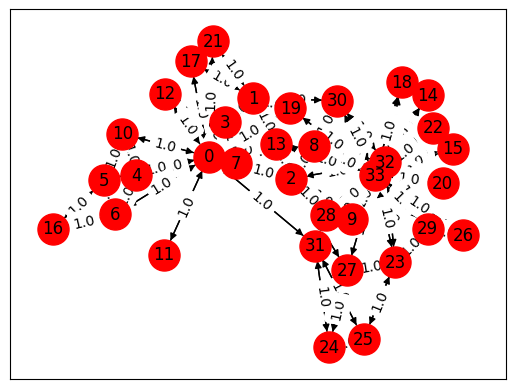

In [ ]:
gb.viz.draw(M)

Проверим, что граф является неориентированным. Чтобы проверить, что граф неориентированный, важно убедиться, что его матрица смежности симметрична. Матрица смежности неориентированного графа является симметричной, если каждый её элемент $A[i][j]$ равен элементу $A[j][i]$. Это означает, что для каждого ребра между вершинами $i$ и $j$ в обратном направлении от $j$ к $i$ существует ребро с тем же весом.

In [ ]:
def is_symmetric_gb(matrix):
    # Создаем новую матрицу как транспонированную копию исходной
    transpose = matrix.T.new()
    # Сравниваем исходную матрицу и её транспонированную версию
    return matrix.isequal(transpose)

In [ ]:
is_symmetric_gb(M)

True

1. Используя `python-graphblas` реализовать наивный алгоритм, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа.
 - Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 - Функция возвращает число — количество треугольников в графе.

In [3]:
def naiveA3(A):
    '''
    Функция подсчитывает количество треугольников в неориентированном графе.
    Args:
    A (Matrix): Матрица смежности графа.
    Returns:
    int: Количество треугольников в графе.
    '''
    # Возводим матрицу А в куб
    tri = A @ A @ A
    # Извлекаем диагональные элементы
    diag = tri.diag()
    # Суммируем все элементы диагонали
    total_triangles = diag.reduce(gb.agg.sum).new()
    # Проверяем, есть ли значение, если нет (все значения диагонали были нулями), возвращаем 0
    if total_triangles.value is None:
        return 0
    else:
        # Результат делим на 6, так как каждый треугольник посчитан шесть раз
        return int(total_triangles.value // 6)

In [ ]:
naiveA3(M)

45

2. Используя `python-graphblas` реализовать наивный алгоритм с маской, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа.
 - Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 - Функция возвращает число — количество треугольников в графе.

In [4]:
def naiveMaskA2(A):
    '''
    Функция подсчитывает количество треугольников в неориентированном графе, используя маску для умножения матриц.
    Args:
    A (Matrix): Матрица смежности графа.
    Returns:
    int: Количество треугольников в графе.
    '''
    # Возводим матрицу А в квадрат с применением маски А
    tri = (A @ A).dup(mask=A.dup(dtype=dtypes.BOOL))
    # Суммируем все элементы
    total_triangles = tri.reduce_scalar(monoid.plus).new()
    # Проверяем, есть ли значение, если нет, возвращаем 0
    if total_triangles.value is None:
        return 0
    else:
        # Результат делим на 6, так как каждый треугольник посчитан шесть раз
        return int(total_triangles.value // 6)

In [ ]:
naiveMaskA2(M)

45

3. Используя `python-graphblas` реализовать Сohen's algorithm, вычисляющий количество треугольников неориентированного графа.
 - Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 - Функция возвращает число — количество треугольников в графе.

In [5]:
def cohen(A):
    '''
    Функция подсчитывает количество треугольников в неориентированном графе, используя алгоритм Кохена
    Args:
    A (Matrix): Матрица смежности графа.
    Returns:
    int: Количество треугольников в графе.
    '''
    # Выбираем нижнюю треугольную часть матрицы
    L = gb.select.tril(A)
    # Выбираем верхнюю треугольную часть матрицы
    U = gb.select.triu(A)
    # Умножаем нижне-треугольную матрицу на верхне-треугольную
    B = L @ U
    # Применяем к результату маску А
    C = B.dup(mask=A.dup(dtype=dtypes.BOOL))
    # Складываем все элементы в получившейся матрице
    total_triangles = C.reduce_scalar(gb.monoid.plus).new()
    # Проверяем, есть ли значение, если нет, возвращаем 0
    if total_triangles.value is None:
        return 0
    else:
        return int(total_triangles.value // 2)

In [ ]:
cohen(M)

45

4. Используя `python-graphblas` реализовать Sandia algorithm, вычисляющий количество треугольников неориентированного графа.
 - Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 - Функция возвращает число — количество треугольников в графе.

In [6]:
def sandia(A):
    """
    Вычисляет количество треугольников в неориентированном графе с использованием алгоритма Sandia.
    Args:
    A (Matrix): Матрица смежности графа.
    Returns:
    int: Количество треугольников в графе.
    """
    # Выбираем нижнюю треугольную часть матрицы
    L = gb.select.tril(A)
    # Умножаем нижнюю треугольную матрицу на себя
    B = L @ L
    # Применяем крезультату маску L
    C = B.dup(mask=L.dup(dtype=dtypes.BOOL))
    # Суммируем все полученные элементы
    total_triangles = C.reduce_scalar(gb.monoid.plus).new()
    if total_triangles.value is None:
        return 0
    else:
        return int(total_triangles)

In [ ]:
sandia(M)

45

5. Используя `python-graphblas` реализовать функцию, вычисляющую для каждой вершины неориентированного графа количество треугольников, в которых она участвует.
 - Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 - Функция возвращает массив, где для каждой вершины указано, в скольки треугольниках она участвует.

In [10]:
def count_triangles_per_vertex(A):
    # Возводим матрицу А в куб
    tri = A @ A @ A
    # Извлекаем диагональные элементы
    diag = tri.diag()
    result = diag.apply(lambda x: x//2)
    return result

In [ ]:
count_triangles_per_vertex(M)

gb.VectorExpression               size  dtype
v_13.apply(unary.<lambda>[FP64])    34   FP64

"Result"   nvals  size  dtype
gb.Vector     32    34   FP64
-----------------------------
index    0     1     2     3    4    5    6    7    8  9   ...   24   25   26  \
value  18.0  12.0  11.0  10.0  2.0  3.0  3.0  6.0  5.0     ...  1.0  1.0  1.0   

index   27   28   29   30   31    32    33  
value  1.0  1.0  4.0  3.0  3.0  13.0  15.0  

Do expr.new() or other << expr to calculate the expression.

6. Добавим тесты для проверки корректности полученных реализаций:

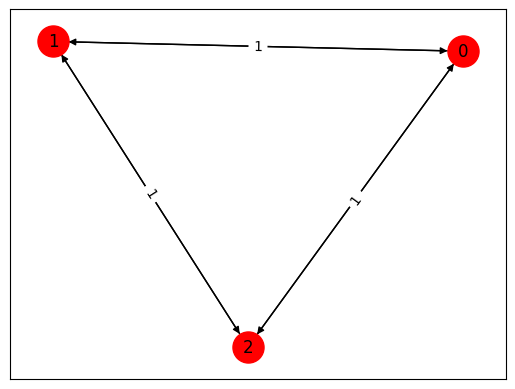

In [16]:
M1 = gb.Matrix.from_coo(
    [0, 0, 1, 1, 2, 2],
    [1, 2, 0, 2, 0, 1],
    [1, 1, 1, 1, 1, 1],
    nrows=3,
    ncols=3
)
gb.viz.draw(M1)

assert naiveA3(M1) == 1
assert naiveMaskA2(M1) == 1
assert cohen(M1) == 1
assert sandia(M1) == 1

In [22]:
count_triangles_per_vertex(M1)

gb.VectorExpression                size  dtype
v_20.apply(unary.<lambda>[INT64])     3  INT64

"Result"   nvals  size  dtype
gb.Vector      3     3  INT64
-----------------------------
index  0  1  2
value  1  1  1

Do expr.new() or other << expr to calculate the expression.

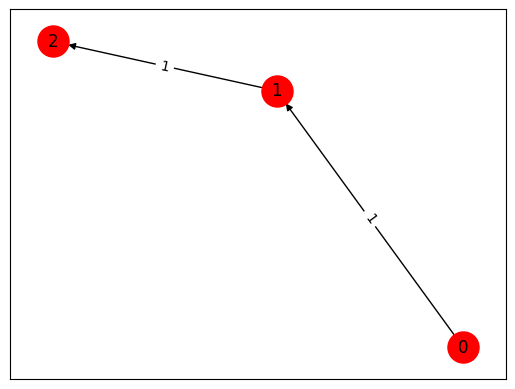

In [24]:
M2 = gb.Matrix.from_coo(
    [0, 1],
    [1, 2],
    [1, 1],
    nrows=3,
    ncols=3
)
gb.viz.draw(M2)

assert naiveA3(M2) == 0
assert naiveMaskA2(M2) == 0
assert cohen(M2) == 0
assert sandia(M2) == 0

In [25]:
count_triangles_per_vertex(M2)

gb.VectorExpression                size  dtype
v_27.apply(unary.<lambda>[INT64])     3  INT64

"Result"   nvals  size  dtype
gb.Vector      0     3  INT64
-----------------------------
index 0 1 2
value      

Do expr.new() or other << expr to calculate the expression.

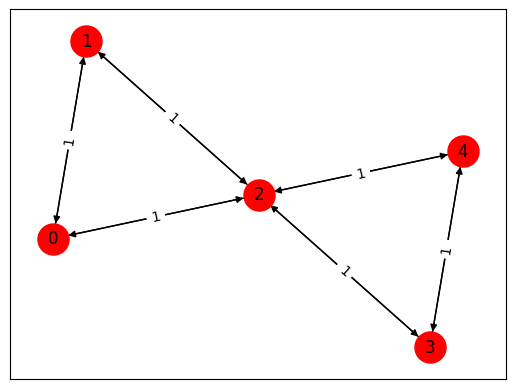

In [26]:
M3 = gb.Matrix.from_coo(
    [0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4],
    [1, 2, 0, 2, 0, 1, 3, 4, 2, 4, 2, 3],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    nrows=5,
    ncols=5
)
gb.viz.draw(M3)

assert naiveA3(M3) == 2
assert naiveMaskA2(M3) == 2
assert cohen(M3) == 2
assert sandia(M3) == 2

In [27]:
count_triangles_per_vertex(M3)

gb.VectorExpression                size  dtype
v_31.apply(unary.<lambda>[INT64])     5  INT64

"Result"   nvals  size  dtype
gb.Vector      5     5  INT64
-----------------------------
index  0  1  2  3  4
value  1  1  2  1  1

Do expr.new() or other << expr to calculate the expression.

7. Скачать 10 графов в формате Matrix Market с сайта SuiteSparse Matrix Collection и оценить время работы всех полученных реализаций. Сделать выводы.
- В качестве фильтров для поиска графов на сайте использовать следующие значения: `Rutherford-Boeing Type = Binary`, `Special Structure = Symmetric`, `Nonzeros.Min = 10000`.

In [ ]:
M1 = mmread('/content/mycielskian9.mtx')
M2 = mmread('/content/G1.mtx')
M3 = mmread('/content/G44.mtx')
M4 = mmread('/content/mycielskian11.mtx')
M5 = mmread('/content/G36.mtx')
M6 = mmread('/content/EX4.mtx')
M7 = mmread('/content/G49.mtx')
M8 = mmread('/content/delaunay_n12.mtx')
M9 = mmread('/content/fxm3_6.mtx')
M10 = mmread('/content/G63.mtx')

In [31]:
def test(A):
    result = [naiveA3(A), naiveMaskA2(A), cohen(A), sandia(A)]
    print(result)
    if not all(element == element for element in result):
       print("All return values are not equal")
    else:
        %timeit naiveA3(A)
        %timeit naiveMaskA2(A)
        %timeit cohen(A)
        %timeit sandia(A)

In [ ]:
test(M1)

[0, 0, 0, 0]
16.6 ms ± 6.84 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.12 ms ± 783 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.34 ms ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
695 µs ± 172 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M2)

[18093, 18093, 18093, 18093]
104 ms ± 58.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.1 ms ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.39 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.69 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test(M3)

[1350, 1350, 1350, 1350]
The slowest run took 4.42 times longer than the fastest. This could mean that an intermediate result is being cached.
92 ms ± 71.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.61 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.34 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.06 ms ± 21.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M4)

[0, 0, 0, 0]
818 ms ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
63.2 ms ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.7 ms ± 445 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.78 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test(M5)

[12679, 12679, 12679, 12679]
180 ms ± 45.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.41 ms ± 410 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.36 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.83 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M6)

[35880, 35880, 35880, 35880]
314 ms ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.9 ms ± 7.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.57 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.17 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test(M7)

[0, 0, 0, 0]
The slowest run took 6.76 times longer than the fastest. This could mean that an intermediate result is being cached.
4.28 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
479 µs ± 84.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
650 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
703 µs ± 159 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M8)

[8215, 8215, 8215, 8215]
16.4 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.03 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.4 ms ± 43.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.87 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M9)

[293737, 293737, 317663, 342426]
86.1 ms ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.3 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
8 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.33 ms ± 4.51 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test(M10)

[42546, 42546, 42546, 42546]
1.94 s ± 387 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
26.7 ms ± 6.97 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.8 ms ± 92.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.35 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Выводы:**
- Наивный алгоритм показывает значительно более низкую скорость работы по сравнению с другими алгоритмами.
- Наивный алгоритм с маской оказывается значительно более эффективным, чем стандартный наивный алгоритм, благодаря избежанию повторного умножения больших матриц, что ускоряет его работу в десятки раз.
- Что касается алгоритмов Коэна и Сандии, то они показывают значительно более высокую производительность. При этом алгоритм Сандии выделяется как наиболее эффективный.

Поэкспериментируем и посмотрим, как влияет время работы алгоритма от количества вершин в графе:

Processed /content/mycielskian9.mtx with 383 vertices.
Processed /content/G1.mtx with 800 vertices.
Processed /content/G44.mtx with 1000 vertices.
Processed /content/mycielskian11.mtx with 1535 vertices.
Processed /content/G36.mtx with 2000 vertices.
Processed /content/EX4.mtx with 2600 vertices.
Processed /content/G49.mtx with 3000 vertices.
Processed /content/delaunay_n12.mtx with 4096 vertices.
Processed /content/fxm3_6.mtx with 5026 vertices.
Processed /content/G63.mtx with 7000 vertices.


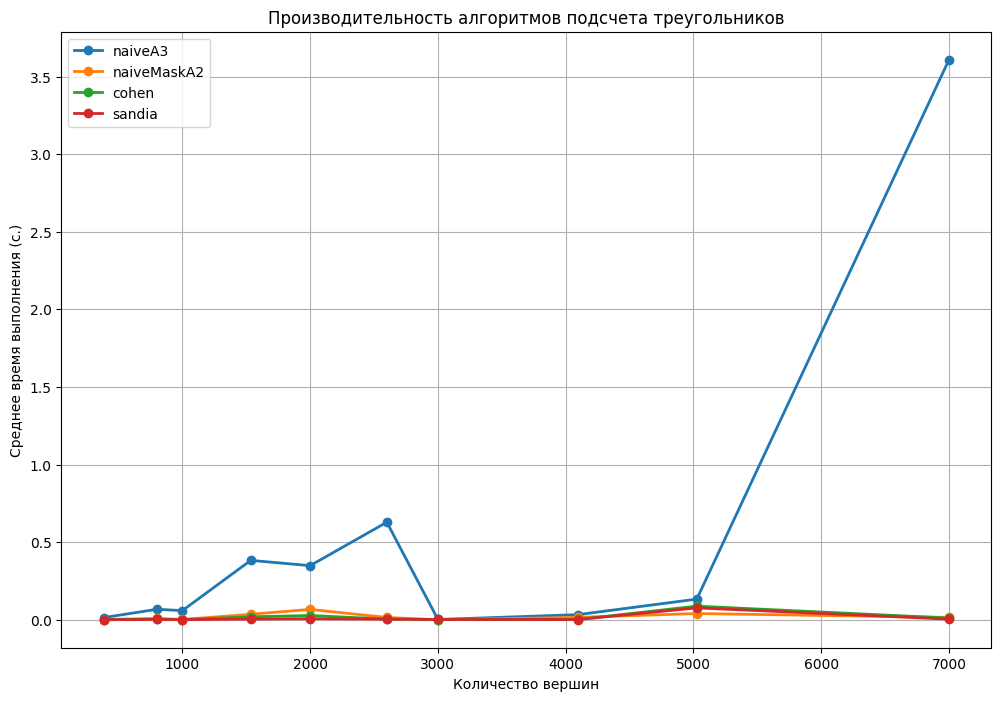

In [ ]:
import matplotlib.pyplot as plt
import timeit

files = [
    '/content/mycielskian9.mtx',
    '/content/G1.mtx',
    '/content/G44.mtx',
    '/content/mycielskian11.mtx',
    '/content/G36.mtx',
    '/content/EX4.mtx',
    '/content/G49.mtx',
    '/content/delaunay_n12.mtx',
    '/content/fxm3_6.mtx',
    '/content/G63.mtx'
]

def test_performance(A):
    functions = [naiveA3, naiveMaskA2, cohen, sandia]
    times = {}
    # Запуск каждой функции и измерение времени выполнения
    for func in functions:
        t = timeit.timeit(lambda: func(A), number=10)
        times[func.__name__] = t / 10  # Среднее время выполнения
    return times

# Словарь для хранения данных времени выполнения
times_data = {func.__name__: [] for func in [naiveA3, naiveMaskA2, cohen, sandia]}
vertex_counts = []

for file_path in files:
    A = mmread(file_path)
    num_vertices = A.shape[0]
    vertex_counts.append(num_vertices)
    times = test_performance(A)
    for name, time in times.items():
        times_data[name].append(time)
    print(f"Processed {file_path} with {num_vertices} vertices.")

# Построение графика
plt.figure(figsize=(12, 8))
for name, times in times_data.items():
    plt.plot(vertex_counts, times, label=name, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Количество вершин')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность алгоритмов подсчета треугольников')
plt.legend()
plt.grid(True)
plt.show()

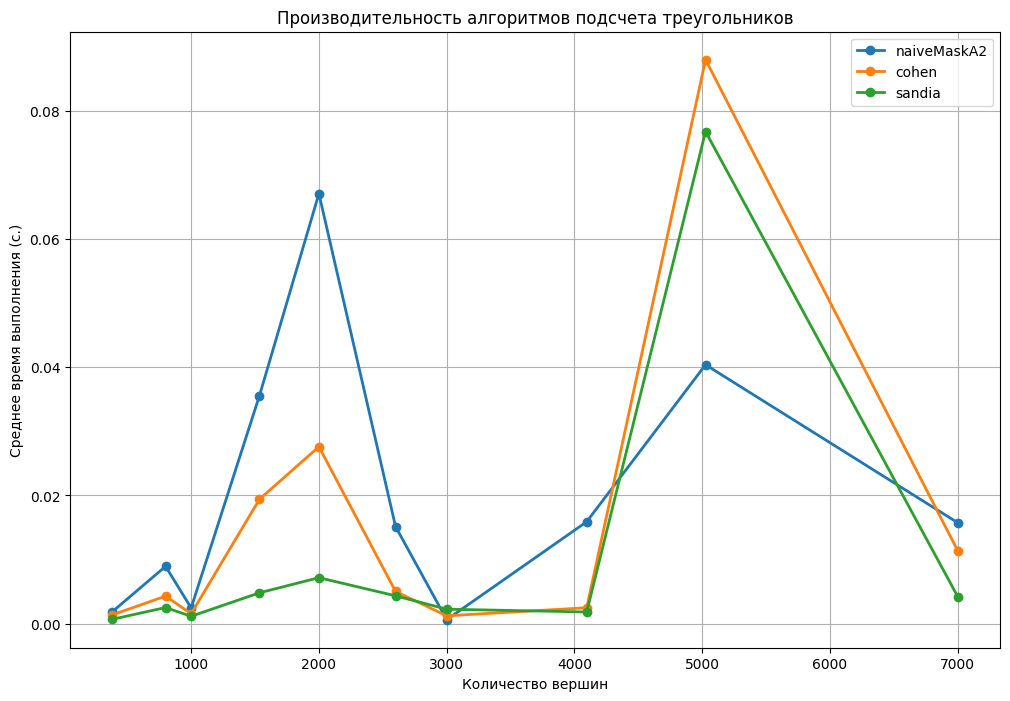

In [ ]:
times_data.pop('naiveA3', None)
plt.figure(figsize=(12, 8))
for name, times in times_data.items():
    plt.plot(vertex_counts, times, label=name, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Количество вершин')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность алгоритмов подсчета треугольников')
plt.legend()
plt.grid(True)
plt.show()

**Выводы:**
- Демонстрирует значительно более высокое время выполнения по сравнению с другими алгоритмами, особенно на больших графах. Это можно объяснить квадратичной сложностью алгоритма при увеличении размера матрицы, что делает его малоэффективным для больших графов.
- Наивный алгоритм с маской работает намного быстрее стандартного наивного алгоритма, особенно на меньших графах. Эффективность уменьшается при росте размера графа, но он все равно остается более предпочтительным выбором для всех размеров по сравнению с naiveA3.
- Алгоритм Сандии выглядит наиболее эффективным на графах среднего размера, но имеет пиковое время на одном из больших графов, что может указывать на особенности структуры этого конкретного графа или на влияние степени разреженности матрицы.
- Алгоритмы Коэна и Сандии являются наилучшим выбором для подсчета треугольников в больших и сложных графах из-за их более низкой временной сложности и лучшей масштабируемости.

8. Реализовать генератор случайных неориентированных графов, в котором можно задавать количество вершин и степень разреженности графа. Путём генерации случайных графов различного размера и с разной степенью разреженности, оценить время работы всех полученных реализаций и исследовать границы их применимости. Сделать выводы.

In [29]:
import random

def generate_random_graph(num_vertices, num_edges):
    # Создаем пустые списки для хранения индексов и значений ребер
    indices_from = []
    indices_to = []
    values = []

    # Генерируем случайные ребра
    edges_added = 0
    while edges_added < num_edges:
        # Генерируем случайную пару вершин
        vertex1 = random.randint(0, num_vertices - 1)
        vertex2 = random.randint(0, num_vertices - 1)

        # Проверяем, что вершины различны и ребро еще не добавлено
        if vertex1 != vertex2 and (vertex1, vertex2) not in zip(indices_from, indices_to):
            # Добавляем индексы вершин и их симметричные пары
            indices_from.append(vertex1)
            indices_to.append(vertex2)
            indices_from.append(vertex2)
            indices_to.append(vertex1)
            # Добавляем значения ребер
            values.extend([1, 1])
            edges_added += 1
    # Создаем COO матрицу из списков индексов и значений
    coo_matrix = gb.Matrix.from_coo(indices_from, indices_to, values, nrows=num_vertices, ncols=num_vertices)
    return coo_matrix

num_vertices = 5
num_edges = 7
random_graph = generate_random_graph(num_vertices, num_edges)
print(random_graph)

"M_147"    nvals  nrows  ncols  dtype         format
gb.Matrix     14      5      5  INT64  bitmapr (iso)
----------------------------------------------------
   0  1  2  3  4
0     1     1   
1  1     1     1
2     1     1  1
3  1     1     1
4     1  1  1   


Исследуем зависимость времени работы алгоритмов от числа вершин графов при фиксированном числе рёбер `n=10` (сильно разряженные графы):

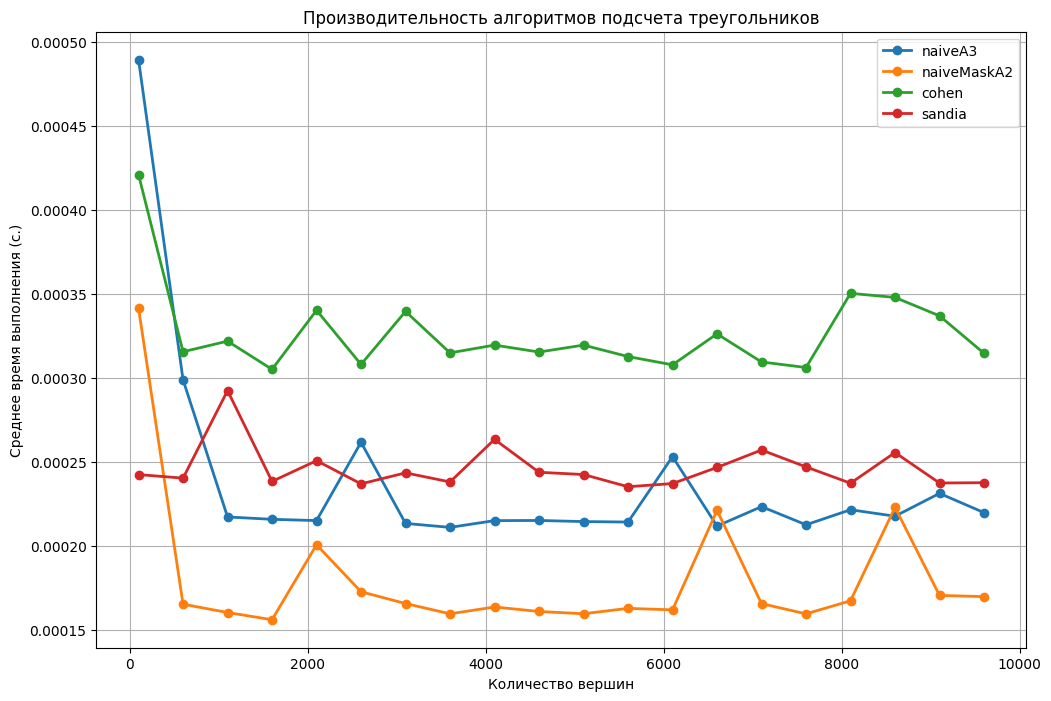

In [38]:
times_data = {func.__name__: [] for func in [naiveA3, naiveMaskA2, cohen, sandia]}
vertex_counts = []

for i in range(100, 10000, 500):
    generated_graph = generate_random_graph(i, 10)
    test_times = test_performance(generated_graph)
    for name, time in test_times.items():
        times_data[name].append(time)
    vertex_counts.append(i)

# Построение графика
plt.figure(figsize=(12, 8))
for name, times in times_data.items():
    plt.plot(vertex_counts, times, label=name, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Количество вершин')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность алгоритмов подсчета треугольников')
plt.legend()
plt.grid(True)
plt.show()

**Выводы:** Наиболее эффективным для сильно разряженных матриц по времени оказался наивный алгоритм с маской, наименее эффективным в данном случае показа себя алгоритм `cohen`

Исследуем зависимость времени работы алгоритмов от плотности графов при фиксированном числе вершин `n=1000`:

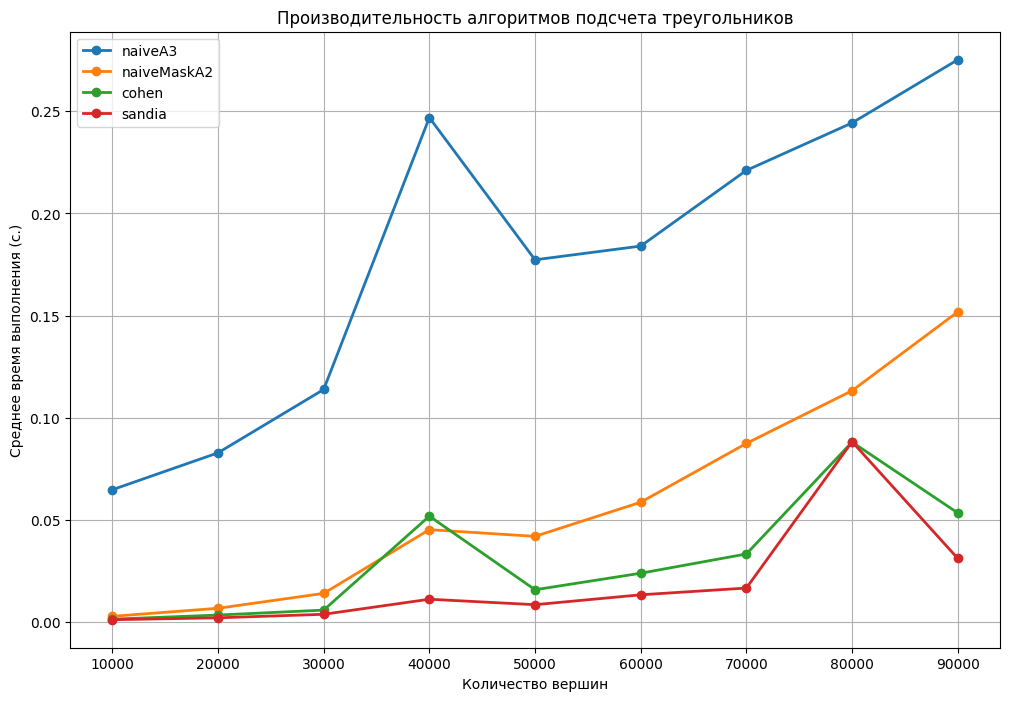

In [39]:
times_data = {func.__name__: [] for func in [naiveA3, naiveMaskA2, cohen, sandia]}
vertex_counts = []

for i in range(10000, 100000, 10000):
    generated_graph = generate_random_graph(1000, i)
    test_times = test_performance(generated_graph)
    for name, time in test_times.items():
        times_data[name].append(time)
    vertex_counts.append(i)

# Построение графика
plt.figure(figsize=(12, 8))
for name, times in times_data.items():
    plt.plot(vertex_counts, times, label=name, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Количество вершин')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность алгоритмов подсчета треугольников')
plt.legend()
plt.grid(True)
plt.show()

**Выводы:** видим, что алгоритмы `Sandia` и `Cohen` наиболее эффективно применять в ситуациях, когда графы обладают высокой плотностью связей. Наивный подход сильно уступает конкурентам

## Итоги работы:
1. Для графов с высокой степенью разреженности наилучшим выбором является использование наивного алгоритма c использованием маски, который оптимизирован для таких условий.

2. В случаях, когда графы обладают большей плотностью связей, алгоритмы `Sandia` и `Cohen` представляют собой более подходящий выбор с точки зрения времени выполнения и использования памяти, при этом `Sandia` часто демонстрирует преимущество.